# Smoothing Images

Smoothing is an image-processing technique that typically applies a **Low-Pass Filter** onto images. This helps remove noise from the image, but typically leads to blurry-looking images.


In this tutorial we will cover the following:
* Smoothing of 1-D Signals
* 2D Convolution Filter
* Image Blurring
    * Averaging : Box Filter & Blur
    * Gaussian Blurring
    * Median Blurring
    * Bilateral Filtering

---

## Standard Imports

In [1]:
import cv2
import numpy as np
from tutorial_utils.utils import *
from matplotlib import pyplot as plt
DATA_DIR = data_dir()

---

## Smoothing of 1-D Signals

This section is meant to provide a quick introduction on Signal Analysis. You may skip it if you have a good intuition of this.

---

### Crash Course on Frequency Content of Signals

Suppose we have a sequence of data values in time (or space). Let's call this sequence as a 'signal'. Joseph Fourier showed that you can decompose any signal into a bunch of super-imposed sinusoids of increasing frequencies. By applying a Fourier Transform to a signal, we can analyze which frequencies (of sinusoids) make up the signal, and using that knowledge, we can modify that signal in interesting ways.

The evolution of 'state' (e.g. velocity) of real world objects is a slow process due to inertia. Sensors measure this 'state' to generate signals. But sensors typically capture data at higher frequencies, and can sometimes have some inaccurate measurements, also called as 'Noise'. Thus, the signals typically contain some low-frequency components corresponding to the evolution of state, and some high-frequency components corresponding to the noise.

---

### Smoothing out a Noisy 1-D signal

Here is an example of what a typical real-world 1-D signal might look like.

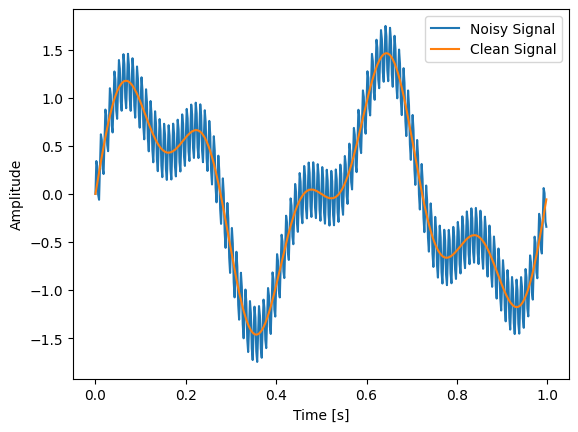

In [37]:
# Sampling setup
fs = 500          # samples per second
duration = 1.0    # seconds
t = np.linspace(0, duration, int(fs*duration), endpoint=False)

# Clean signal: two low-frequency sinusoids
signal_clean = np.sin(2*np.pi*2*t) + 0.5*np.sin(2*np.pi*5*t)

# Add high-frequency noise
noise = 0.3*np.sin(2*np.pi*100*t)
signal_noisy = signal_clean + noise

# Plot
plt.plot(t, signal_noisy, label="Noisy Signal")
plt.plot(t, signal_clean, label="Clean Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

We can apply a Fast Fourier Transform to analyze this signal

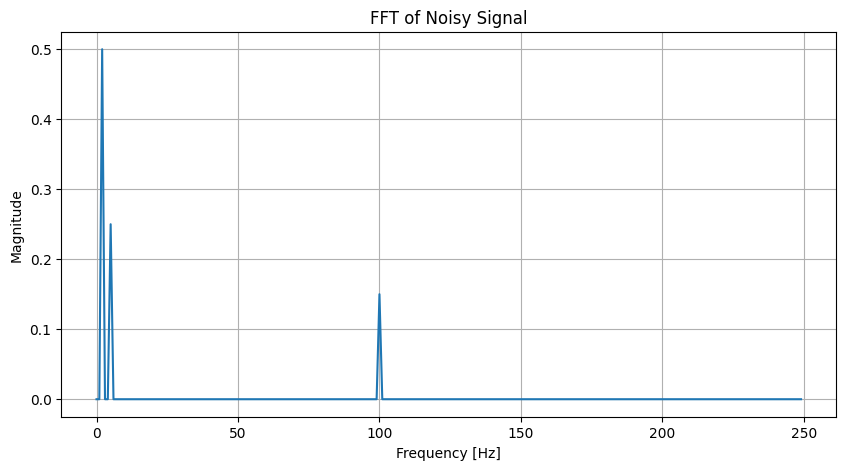

In [38]:
# --- FFT ---
N = len(signal_noisy)                       # number of samples
fft_vals = np.fft.fft(signal_noisy)         # compute FFT
fft_freqs = np.fft.fftfreq(N, 1/fs)         # frequency bins

# Only take the positive half of the spectrum
pos_mask = fft_freqs >= 0
fft_freqs = fft_freqs[pos_mask]
fft_vals = np.abs(fft_vals[pos_mask]) / N   # magnitude spectrum

# --- Plot ---
plt.figure(figsize=(10,5))
plt.plot(fft_freqs, fft_vals)
plt.title("FFT of Noisy Signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()

As you can see, the signal has some core data of frequency < 6Hz, and high-frequency noise of 100Hz. If we want to remove the high-frequency component, we need to design a **Low-Pass Filter** i.e. *only keep the sinusoid components whose frequencies are lower than some threshold / 'cutoff' value*.

An **Exponential Filter** is a common type of Low-Pass Filter. 

$y[t] = \alpha \cdot y[t-1] + (1 - \alpha) \cdot x[t]$

where $y[t]$ is the filtered output signal, $x[t]$ is the unfiltered input signal, and $y[t-1]$ is the filtered output of the previous timestep.

The parameter $\alpha$ can be related to the desired cutoff frequency $f_{c}$ using:

$\alpha = e^{\frac{- 2 \pi f_{c}}{F_{s}}}$ where $F_{s}$ is the sampling rate of the signal.

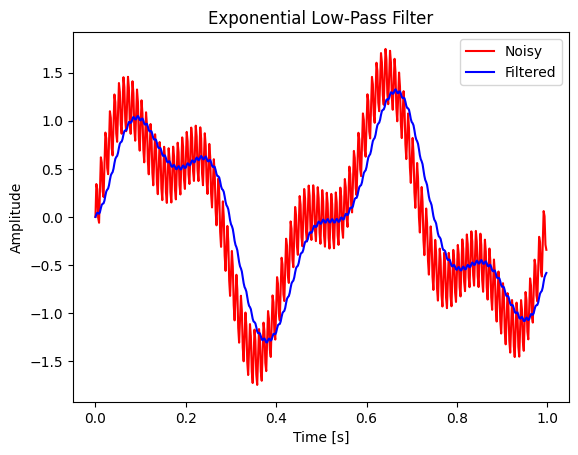

In [39]:
fc = 6 # Cutoff Frequency

# Compute alpha from fc
alpha = np.exp(-2 * np.pi * fc / fs)


# Apply LPF 
y = np.zeros_like(signal_noisy)
y[0] = signal_noisy[0]
for n in range(1, len(signal_noisy)):
    y[n] = alpha * y[n-1] + (1-alpha) * signal_noisy[n]

plt.plot(t, signal_noisy, 'r', label='Noisy')
plt.plot(t, y, 'b', label='Filtered')
plt.title("Exponential Low-Pass Filter")
plt.xlabel("Time [s]"); plt.ylabel("Amplitude")
plt.legend()

So you can see that by applying an LPF, the noisy components are now removed and we obtain the (almost*) clean signal. 

**Note**:  There are many types of LPFs, but we show the exponential filter for an easy demonstration. Exponential filters can cause **phase-shifts** i.e. the cleaned signal gets shifted/delayed in time. There are ways one can remedy this, but that's out of scope for this tutorial; the important takeaway is that such shifts may also happen when applying Low-Pass Filters to images if we are not careful.

---

### 1D Convolution to filter 1D Signals

Now that we understand what Low-Pass Filtering does to a 1-D signal, let's talk about **Convolution**. The general, mathematical definition of convolution can be found in many texts on signal processing and control theory, but for the purposes of this tutorial, the simple explanation is more intuitive.

Suppose we have a list of 100 numbers. We want to create a new list of numbers where each number is the Median of itself and 4 of its neighbors, 2 from each side.

To do this, we apply a 'Sliding Window' on the list to select the element and its neighbors, then 'process' that window to obtain a value. The 'process' could be taking a median, max, min, average, or any other operation that outputs a single value.

This 'Sliding Window' is called the **kernel**. 

Here is an example in code.

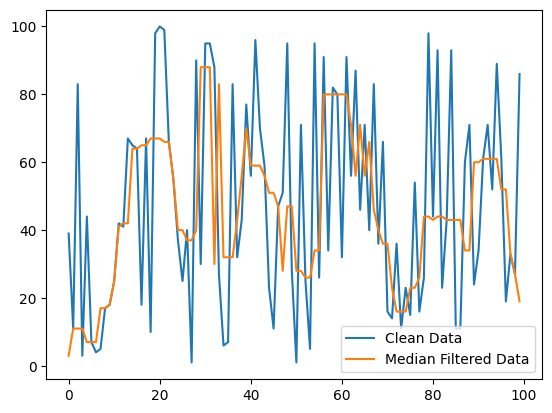

In [51]:
import random

def process_window(ls):
    '''
    Calculate median
    '''
    return np.median(ls)


# List of 100 numbers
nums = [random.randint(0,100) for _ in range(100)]
clean_nums = nums.copy()
x = np.arange(0, 100, 1)

# Size of the sliding window
kernel_size = 7 

# Pad nums with 0's equal to kernel_size // 2
nums = [0]*(kernel_size//2) + nums + [0]*(kernel_size//2)

# Run filter on data
filt_nums = []
for i in range(len(nums) - kernel_size + 1):
    window = nums[i:i+kernel_size]

    # Process the window/kernel elements
    elem = process_window(window)

    filt_nums.append(elem)

plt.plot(x, clean_nums, label="Clean Data")
plt.plot(x, filt_nums, label="Median Filtered Data")
plt.legend()

---

## 2D Convolution Filter for Images

Images are 2D signals. Instead of a 'time' axis, they have a 'row' and 'column' axis, so that each (row, column) pair has a data value.

Just like 1D signals, images can also be filtered with various types of filters; we can apply our intuition of what happens in 1D filtering, to 2D filtering as well.

### Convolving with a generic kernel

OpenCV provides `cv2.filter2D()` to **convolve** a kernel with an image. This lets us define the kernel as we like. This function takes the following arguments:
* Input image
* Desired Output Image Depth (datatype used to represent each pixel's value)
    * `-1` means that the output image has the same datatype as the input
    *  `CV_8U` : Unsigned 8-bit integers (0-255)
    *  `CV_16U` : Unsigned 16-bit integers
    *  `CV_32F` : 32-bit floating point numbers
    *  `CV_64F` : 64-bit floating point numbers
    *  You can choose a different depth than the input image if the filtering operation might result in values that exceed the original range. If you expect the filtered values to exceed the original range, but choose to keep the same depth, the filtered values may get clipped/saturated.
* Kernel

### Example

Suppose we want to define a kernel that computes the mean of all pixels that it overlays. A 5x5 kernel would be defined as:

$K = \frac{1}{25}\begin{bmatrix}1 & 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 & 1\end{bmatrix}$


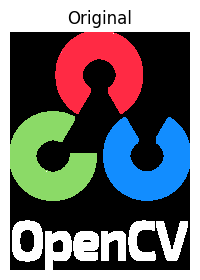

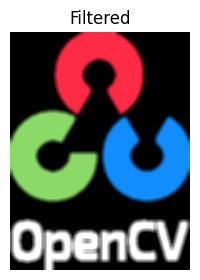

In [76]:
img = cv2.imread(DATA_DIR + "opencv-logo-white.png")
cv2_imshow(img, 'Original')


# Define a kernel
kernel = np.ones((5,5), np.float32)/25

# Apply filter
dst = cv2.filter2D(img, -1, kernel)

cv2_imshow(dst, "Filtered")

---

## Image Blurring

Image blurring is achieved by convolving the image with a Low-Pass Filter kernel. It is useful for removing noise. 

In 1-D signals, we have seen that (high-frequency) noise leads to large changes in the values of adjacent data-points - like 'peaks' and 'valleys'. In 2D images, **edges** or boundaries of objects typically exhibit this type of behavior; the intensity of pixels adjacent to the boundaries tend to be much higher or much lower.


When we apply a smoothing filter, it reduces these peaks and valleys. Thus, the 'edges' start disappearing, which is what gives the image a 'blurred' look, because edges are how our eyes identify separate regions of the image.

You can see this in action in the below example code.
* First we create an image that has a clearly defined 'edge'.
* We display a 'cross-section' of that image i.e. X-axis coordinates v/s Intensity values for the middle row in that image
* Then we apply a filter on the image, plot it and its cross-section for comparison

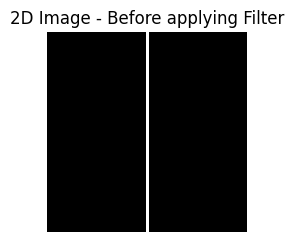

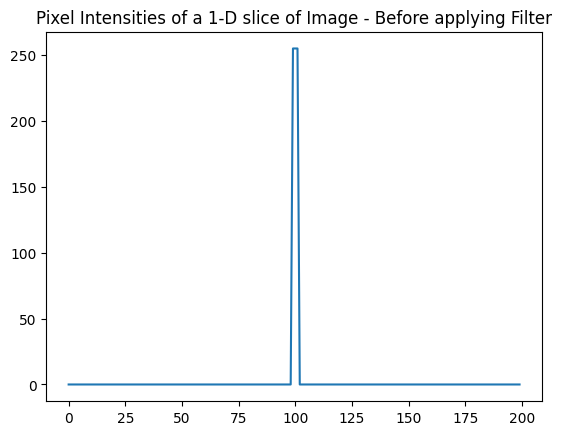

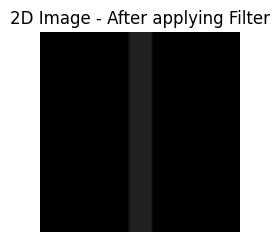

Text(0.5, 1.0, 'Pixel Intensities of a 1-D slice of Image - After applying Filter')

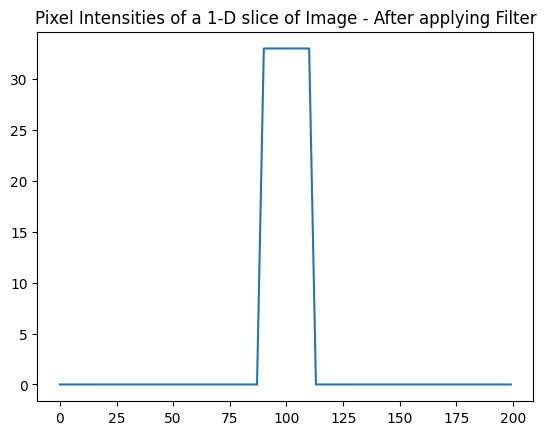

In [75]:
# Make an image that has an 'edge'
img = np.zeros((200,200), dtype=np.uint8)
img[:, 99:102] = 255
x_axis = np.arange(0, 200, 1)
cv2_imshow(img, "2D Image - Before applying Filter")

# Display a slice of that image
plt.plot(x_axis, img[100, :])
plt.title("Pixel Intensities of a 1-D slice of Image - Before applying Filter")

# Now filter the image

ksize = 23
kernel = np.ones((ksize,ksize), np.float32)/(ksize**2)
dst = cv2.filter2D(img, -1, kernel)
cv2_imshow(dst, "2D Image - After applying Filter")

plt.plot(x_axis, dst[100, :])
plt.title("Pixel Intensities of a 1-D slice of Image - After applying Filter")



---

### Averaging Filters (Blur, BoxFilter)

Averaging filters are a common convolution operation, so OpenCV provides them as standalone functions `cv2.blur()` and `cv2.boxFilter()`. Both these functions do the exact same operation, but the difference lies in whether or not the kernel can be normalized. `blur` is very simple. `boxFilter` offers more customization.

In general, a normalized Box Filter has the kernel:

$K_{N} = \frac{1}{N^{2}}\begin{bmatrix}1 & 1 & 1 & 1... & 1 \\ 1 & 1 & 1 & 1... & 1 \\ 1 & 1 & 1 & 1... & 1  \\ ... \\ 1 & 1 & 1 & 1... & 1\end{bmatrix}$

This kernel is used by default in both `blur` and `boxFilter` operations. 
* However, `boxFilter` has an argument `normalize`, which when set to `False`, will not perform the $\frac{1}{N^{2}}$ division. In other words, if `normalize=False`, `boxFilter` computes a sum, not an average.
* `boxFilter` also has a `ddepth` argument to set the desired output image depth.

--- 

#### Example

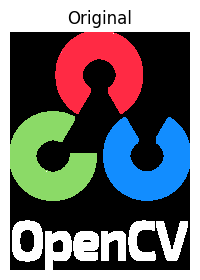

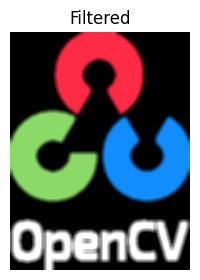

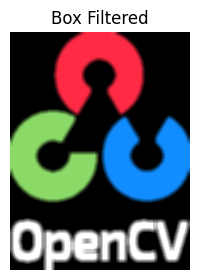

In [81]:
img = cv2.imread(DATA_DIR + "opencv-logo-white.png")
cv2_imshow(img, 'Original')


# Define kernel size
kernelsize = (5,5)

# Apply blur
blur = cv2.blur(img, kernelsize)

# Apply box filter
boxfilt = cv2.boxFilter(img, -1, kernelsize)

cv2_imshow(blur, "Filtered")
cv2_imshow(boxfilt, "Box Filtered")

---

### Gaussian Blurring

Gaussian blurring is highly effective at removing Gaussian Noise from an image. It often leads to more 'natural-looking' denoised images.

#### Gaussian Noise

We know that real-world signals consist of the 'clean' underlying data, with some (random) noise. It has been found that this random noise is modeled very well by Gaussian distributions.

Take a look at this example image. Suppose we measure a 'clean' signal, that has a value of 0, using a sensor. There is noise in the sensor measurements. Some of the measurements are negative, and some are positive. If we plot a histogram of the noise values, we see the familiar Gaussian (bell) curve. We notice that most of the noise has very low magnitude in either direction, and that larger magnitude noise is rare.

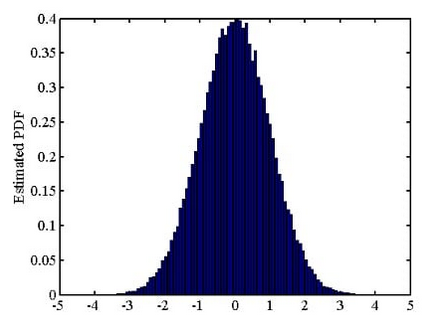



#### Gaussian Kernels

We can imagine a kernel whose values make this type of bell-curve shape. The middle element of the kernel is weighted heavily compared to the edge elements of the kernel.

Since the mean value is 0, such kernels can be expressed in terms of their standard deviations along the X and Y axes. 

OpenCV provides `cv2.GaussianBlur()` that lets you apply a Gaussian Kernel over the image. This function takes as parameters:
* Input image
* Kernel Size **(MUST BE ODD AND POSITIVE)**
* sigmaX and sigmaY
    * If only one is provided, then it is assumed sigmaX == sigmaY
    * If both are 0, the Standard Deviation is calculated from the kernel size
        * The formula used by OpenCV to calculate this is $0.3 (\sqrt{ksize-1} - 1) + 0.8$ where $ksize$ is the dimension of the Gaussian kernel
        * This formula aims to ensure that approx. 99.7% i.e. $\pm 3\sigma$ of the Gaussian Distribution's probability mass falls within the kernel's extent.

#### Example

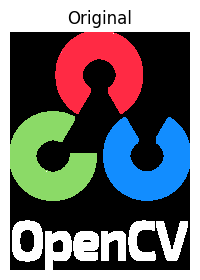

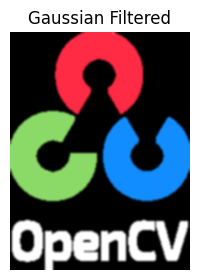

In [83]:
img = cv2.imread(DATA_DIR + "opencv-logo-white.png")
cv2_imshow(img, 'Original')


# Define kernel size
kernelsize = (5,5)

# Apply Gaussian blur where std_dev is calculated from kernelsize
gblur = cv2.GaussianBlur(img, kernelsize, 0)

cv2_imshow(gblur, "Gaussian Filtered")


---

### Median Blurring

Median Filters are useful at outlier rejection. If you've ever observed low-frequency erratic 'spikes' in a 1D signal, such spikes are outliers, and can be removed via 1D median filters.

In 2D images, these 'outliers'/spikes take the form of Salt and Pepper noise i.e noise whose values tend to be close to either end of the pixel intensity range, therefore appearing as Black and White dots.

OpenCV provides `cv2.medianBlur()` to filter out such noise. It takes as arguments:
* Image
* Kernel Size : **Positive Odd Integer**

#### Example

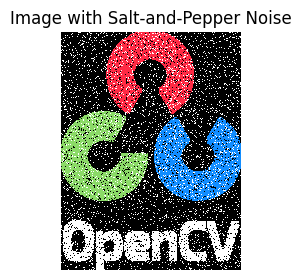

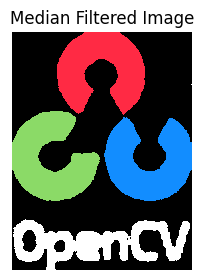

In [95]:
img = cv2.imread(DATA_DIR + "opencv-logo-white.png")

# Add some salt-and-pepper noise to this
probabilities = np.random.random(img.shape[:2])
k = 0.2
img[probabilities < (k / 2)] = np.array([0, 0, 0], dtype=np.uint8)
img[probabilities > 1 - (k / 2)] = np.array([255, 255, 255], dtype=np.uint8)
cv2_imshow(img, "Image with Salt-and-Pepper Noise")


# Now do some Median Filtering
median = cv2.medianBlur(img, 5)
cv2_imshow(median, "Median Filtered Image")

---

### Bilateral Filtering

The biggest issue of the above noise-removal methods is that edges get blurred. 